In [68]:
# !pip install --upgrade pandas_datareader
# !pip install yfinance


In [153]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt 
# from pandas_datareader import data as pdr
import yfinance as yf

import seaborn as sns
from scipy.stats import skew, kurtosis


## Define Stock list

In [78]:
# stock_list = ['CBA', 'BHP', 'TLS', 'MSFT']
# stock_list = ['msft', 'aapl', 'goog']
# stock_list = ['MSFT', 'AAPL', 'GOOG']
# stock_list = ['F', 'TSLA', 'BYND', "DIS"]
# stock_list = ['TSLA', 'BYND', "DIS"]
stock_list = ['BYND', "DIS"]

stock_list = list(map(lambda x: x.lower(), stock_list))

yf_stock_list = " ".join(stock_list)
yf_stock_list

'bynd dis'

## Yfin Ticker examples 

[*********************100%***********************]  1 of 1 completed


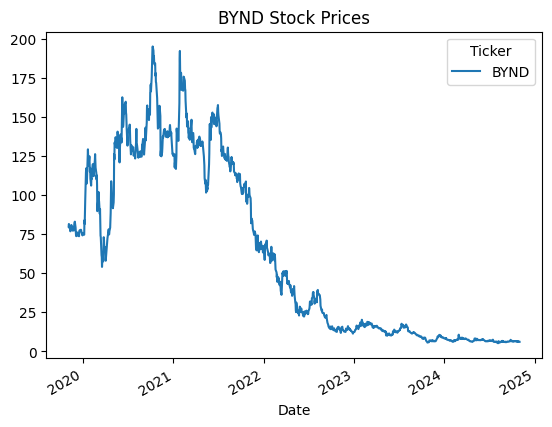

In [115]:
# access each ticker using (example)
# tickers.tickers['MSFT'].info
# tickers.tickers['AAPL'].history(period="1mo")['Close']
# tickers.tickers['GOOG'].actions

# data = yf.download("AAPL", start="2020-01-01", end="2022-01-01")
stock = stock_list[0]

data = yf.download(stock, period='5y')
data['Close'].plot()
plt.title(f"{stock.upper()} Stock Prices")
plt.show()

[*********************100%***********************]  1 of 1 completed


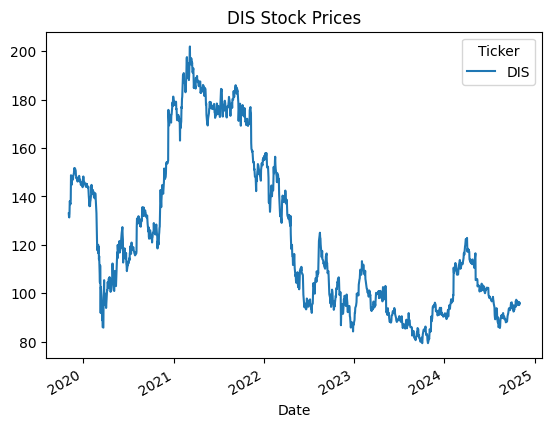

In [122]:
stock = stock_list[1]

data = yf.download(stock, period='5y')
data['Close'].plot()
plt.title(f"{stock.upper()} Stock Prices")
plt.show()

In [48]:
data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BYND,BYND,BYND,BYND,BYND,BYND
Date,,,,,,
2020-01-02 00:00:00+00:00,75.639999,75.639999,77.199997,75.260002,76.230003,2221700
2020-01-03 00:00:00+00:00,75.410004,75.410004,76.199997,74.314003,75.120003,1628700
2020-01-06 00:00:00+00:00,74.589996,74.589996,75.750000,73.830002,74.970001,2324700
2020-01-07 00:00:00+00:00,83.889999,83.889999,84.879997,75.000000,75.000000,12044600
2020-01-08 00:00:00+00:00,81.480003,81.480003,88.269997,81.160004,86.000000,18216000
...,...,...,...,...,...,...
2022-06-24 00:00:00+00:00,25.420000,25.420000,27.184999,24.600000,26.400000,9299200
2022-06-27 00:00:00+00:00,25.180000,25.180000,26.198999,23.860001,25.652000,3460800


## Get Data

In [81]:
def get_means_cov(tickers, stock_list, period="1y"):
    mean_returns = []
    stock_list_data = []

    for stock in stock_list:
        stock_data = tickers.tickers[stock.upper()].history(period=period)["Close"]
        returns = stock_data.pct_change()
        mean_returns.append(returns.mean())
        stock_list_data.append(returns)


    prices_array = np.array(stock_list_data)
    mask = ~np.isnan(prices_array).any(axis=0)  # Find columns without any NaNs

    # Filter the array to keep only columns without NaN values
    filtered_prices = prices_array[:, mask]

    # Calculate the covariance matrix
    cov_matrix = np.cov(filtered_prices)

    # return mean_returns, stock_list_data.cov() 
    return mean_returns, cov_matrix

In [82]:
tickers = yf.Tickers(yf_stock_list)
mean_returns, cov_matrix = get_means_cov(tickers, stock_list, period='5y')

In [107]:
print(mean_returns)
print(cov_matrix)

[-0.0008586385493978282, -2.116311783145677e-05]
[[0.00243532 0.00034223]
 [0.00034223 0.00045784]]


## MC Sim

In [116]:
# weights is how many percent of portfolio goes into stock
weights = np.random.random(len(mean_returns))
weights /= np.sum(weights)   # normalize weights to sum up to 1 
weights

array([0.48870884, 0.51129116])

In [96]:
# weights = np.array([0.15, 0.15,0.7])

### MC SIM Vars 

In [117]:
mc_sims = 500
T = 600 # timeframe in days 100 days in code 

mean_matrix = np.full(shape=(T, len(weights)), fill_value=mean_returns)
mean_matrix = mean_matrix.T 

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initial_portfolio_value = 10000


### MC SIM Loop

In [127]:
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_matrix + np.inner(L, Z)
    # print(daily_returns)

    # cumulative effect of daily changes 
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio_value

In [133]:
portfolio_sims.shape
print(f'{T} days with {mc_sims} possibilities')

600 days with 500 possibilities


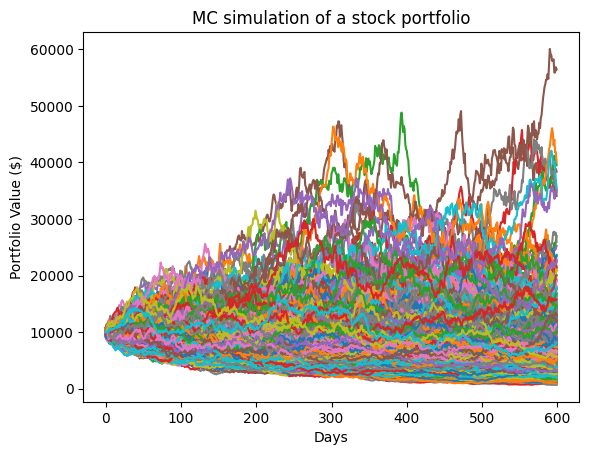

In [134]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [154]:
# Assuming portfolio_sims is your array and T is the final time step
final_portfolio_values = portfolio_sims[T-1, ]

# Summary statistics
max_value = final_portfolio_values.max()
min_value = final_portfolio_values.min()
mean_value = final_portfolio_values.mean()
variance = final_portfolio_values.var()
std_dev = final_portfolio_values.std()
skewness = skew(final_portfolio_values)
kurtosis_value = kurtosis(final_portfolio_values)

# Value at Risk (VaR) at different confidence levels
VaR_95 = np.percentile(final_portfolio_values, 5)   # 5th percentile for 95% VaR
VaR_99 = np.percentile(final_portfolio_values, 1)   # 1st percentile for 99% VaR

# Print summary statistics
print(f'Max from simulations: {max_value:,.2f}')
print(f'Min from simulations: {min_value:,.2f}')
print(f'Mean from simulations: {mean_value:,.2f}')
print(f'Variance from simulations: {variance:,.2f}')
print(f'Standard Deviation from simulations: {std_dev:,.2f}')
print(f'Skewness from simulations: {skewness:,.2f}')
print(f'Kurtosis from simulations: {kurtosis_value:,.2f}')
print(f'Value at Risk (95%): {VaR_95:,.2f}')
print(f'Value at Risk (99%): {VaR_99:,.2f}')

Max from simulations: 56,421.59
Min from simulations: 687.91
Mean from simulations: 7,979.25
Variance from simulations: 40,811,832.72
Standard Deviation from simulations: 6,388.41
Skewness from simulations: 2.59
Kurtosis from simulations: 10.97
Value at Risk (95%): 1,809.76
Value at Risk (99%): 1,062.16


C:\Users\zanel\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zanel\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


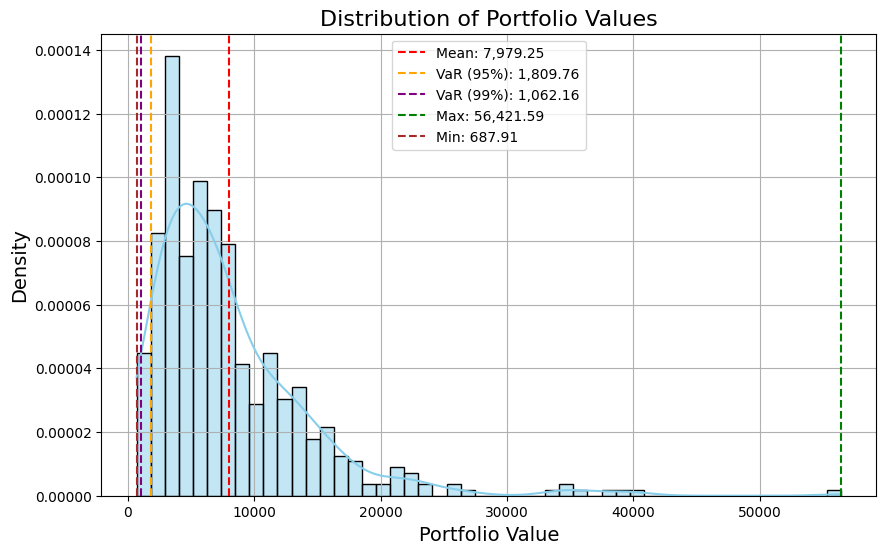

In [162]:
# Plotting the distribution of final portfolio values
plt.figure(figsize=(10, 6))
sns.histplot(final_portfolio_values, bins=50, kde=True, color='skyblue', stat='density')

# Adding labels and title
plt.title('Distribution of Portfolio Values', fontsize=16)
plt.xlabel('Portfolio Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Displaying summary statistics on the plot
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:,.2f}')
plt.axvline(VaR_95, color='orange', linestyle='--', label=f'VaR (95%): {VaR_95:,.2f}')
plt.axvline(VaR_99, color='purple', linestyle='--', label=f'VaR (99%): {VaR_99:,.2f}')
plt.axvline(max_value, color='green', linestyle='--', label=f'Max: {max_value:,.2f}')
plt.axvline(min_value, color='brown', linestyle='--', label=f'Min: {min_value:,.2f}')

# Adding legend
plt.legend()
plt.grid(True)
plt.show()

In [158]:
count = np.sum(portfolio_sims[T-1, ]> initial_portfolio_value)

print(f'Number of winning simulations: {count:,}')

Number of winning simulations: 132


The percentage change that is taken is based on closing price day_t-1 and closing price day_t over closing price day_t. It is like buying in with the portfolio weight*initial_portfolio_value on stock on day_t-1 and selling it at closing price on day_t.

The simulation is optimistic even though the stocks I've specifically chosen Beyond Meat and Disney has dropped in value relatively significantly over the last 5 years. Why?

How can a "losing" stock be giving us "winning" simulations? 

This is explained by the mean_returns by both stocks over the last 5 years. both mean_returns have means with very small values but the variances are relatively high caused by the significant dips over a short period. Taking the mean and variance over the last 5 years is not a good representation at all to be fair. We did not incorporate the skewness and kurtosis of the distribution, specifically we assumed that our daily returns over the next 100 days will follow a normal distribution with a mean and covariance based on its 5 year history. This is a very strong assumption that isn't backed by any analysis. Why MVN? We chose it for simplicity. 

 This circles back to the fact that this is just a pet project and more features should be incorporated into the MC simulation for more reliable results.  

# Markov Chain MC 

## Metropolis Hasting 

We are assuming daily returns are distributed by MVN(\mu, \sigma)

In [ ]:
# https://exowanderer.medium.com/metropolis-hastings-mcmc-from-scratch-in-python-c21e53c485b7

In [248]:
# mean_matrix_mcmc = np.full(shape=(T, len(weights)), fill_value=0.0)
# mean_matrix_mcmc[0,] = mean_returns
# mean_matrix_mcmc.T.shape


### MH Functions

In [15]:
def likelihood(x, mean_matrix, cov_matrix):
    # Standard Normal Distribution
    # An underlying assumption of linear regression is that the residuals
    # are Gaussian Normal Distributed; often, Standard Normal distributed
    # return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

    # MVN 
    mu = mean_matrix
    sigma = cov_matrix
    p = len(mean_matrix) # number of param

    diff = x - mu
    mahalanobis_distance = np.dot(np.dot(diff, np.linalg.inv(sigma)), diff.T)

    # print("CALLED")
    # print(mahalanobis_distance)

    return ((2*np.pi)**(p/2)) * (np.linalg.det(sigma)**(-0.5)) * np.exp(-0.5* mahalanobis_distance) 


In [16]:
def proposal_distribution(mu, sigma):
    # Select the proposed state (new guess) from a Gaussian distribution
    #  centered at the current state, within a Guassian of width `stepsize`
    # p = len(mu)
    p = mu.shape[1]
    Z = np.random.normal(size=(1,p))
    L = np.linalg.cholesky(sigma)
    metro_step = mu + np.dot(Z, L)  # daily returns 
    return metro_step

In [17]:
def mcmc_updater(curr_state, curr_likeli, 
                 likelihood, proposal_distribution, mu, sigma):
  """ Propose a new state and compare the likelihoods

  Given the current state (initially random), 
    current likelihood, the likelihood function, and 
    the transition (proposal) distribution, `mcmc_updater` generates 
    a new proposal, evaluate its likelihood, compares that to the current 
    likelihood with a uniformly samples threshold, 
  then it returns new or current state in the MCMC chain.

  Args:
      curr_state (float): the current parameter/state value
      curr_likeli (float): the current likelihood estimate
      likelihood (function): a function handle to compute the likelihood
      proposal_distribution (function): a function handle to compute the 
        next proposal state

  Returns:
      (tuple): either the current state or the new state
        and its corresponding likelihood
  """
  # Generate a proposal state using the proposal distribution
  # Proposal state == new guess state to be compared to current
  proposal_state = proposal_distribution(mu=curr_state, sigma=sigma)

  # Calculate the acceptance criterion
  prop_likeli = likelihood(proposal_state, mu, sigma)
  accept_crit = prop_likeli / curr_likeli

  # Generate a random number between 0 and 1
  accept_threshold = np.random.uniform(0, 1)


  # If the acceptance criterion is greater than the random number,
  # accept the proposal state as the current state
  if accept_crit > accept_threshold:
      return proposal_state, prop_likeli

  # Else
  return curr_state, curr_likeli

In [18]:
def metropolis_hastings(
        likelihood, proposal_distribution, initial_state, 
        num_samples, mu=mean_matrix,  sigma=cov_matrix, burnin=0.2):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        stepsize: is basically sigma 
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []

    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(curr_state, mu, sigma)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_likeli = mcmc_updater(
            curr_state=curr_state,
            curr_likeli=curr_likeli,
            likelihood=likelihood,
            proposal_distribution=proposal_distribution,
            mu=mu,
            sigma=sigma
        )

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            samples.append(curr_state)

            # daily_returns = curr_state
            # portfolio_sims[:,i-idx_burnin] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio_value

    return np.array(samples)


### MH SIM

In [19]:
mcmc_chains = 500
mcmc_sims = 20000 
burnin = 0.5

# sim timeframe
T = 100 # timeframe in days 100 days in code

# mean_matrix_mcmc = np.full(shape=(T, len(weights)), fill_value=0.0)
# # mean_matrix_mcmc 
# mean_matrix_mcmc = mean_matrix_mcmc.T 

portfolio_sims_mcmc = np.full(shape=(T, int((1-burnin)*mcmc_sims)), fill_value=0.0)
initial_portfolio_value = 10000

np.random.seed(42)

mean_returns_mcmc = np.array(mean_returns)
mean_returns_mcmc = mean_returns_mcmc.reshape(1, 4)
initial_state = np.array([0 for _ in range(len(weights))]).reshape(1,4)  # Trivial case, starting at the mode of the likelihood

In [20]:
samples = metropolis_hastings(
    likelihood,
    proposal_distribution,
    initial_state,
    mcmc_sims,
    mu=mean_returns,
    sigma=cov_matrix,
    burnin=burnin
)

# samples

In [21]:
np.array(samples).shape


(10000, 1, 4)

In [22]:
samples

array([[[ 0.01338139,  0.06492887,  0.0315409 , -0.0055737 ]],

       [[ 0.01338139,  0.06492887,  0.0315409 , -0.0055737 ]],

       [[ 0.01338139,  0.06492887,  0.0315409 , -0.0055737 ]],

       ...,

       [[-0.00727066,  0.00884113, -0.01562167,  0.00496487]],

       [[-0.00727066,  0.00884113, -0.01562167,  0.00496487]],

       [[-0.00727066,  0.00884113, -0.01562167,  0.00496487]]])

In [23]:
samples[:,0,:].shape

(10000, 4)

In [24]:
portfolio_sims[:,0].shape


(100,)

In [25]:
samples[:T, 0,].shape

(100, 4)

In [26]:
weights

array([0.05307382, 0.43035643, 0.34531141, 0.17125834])

In [27]:
daily_returns = samples[:T, 0,]

In [28]:
daily_returns

array([[ 0.01338139,  0.06492887,  0.0315409 , -0.0055737 ],
       [ 0.01338139,  0.06492887,  0.0315409 , -0.0055737 ],
       [ 0.01338139,  0.06492887,  0.0315409 , -0.0055737 ],
       [ 0.05930228,  0.05109668,  0.08512917,  0.01559513],
       [ 0.05930228,  0.05109668,  0.08512917,  0.01559513],
       [ 0.05930228,  0.05109668,  0.08512917,  0.01559513],
       [ 0.05930228,  0.05109668,  0.08512917,  0.01559513],
       [ 0.04066393,  0.01367214,  0.08197714,  0.01101054],
       [ 0.01271373, -0.04504634,  0.02423059,  0.01555965],
       [-0.00028392, -0.03268595, -0.01865799,  0.02115081],
       [-0.00028392, -0.03268595, -0.01865799,  0.02115081],
       [ 0.03192382,  0.00243567,  0.04205436,  0.02635262],
       [ 0.03192382,  0.00243567,  0.04205436,  0.02635262],
       [-0.004515  , -0.04136597,  0.04525389,  0.02180147],
       [-0.004515  , -0.04136597,  0.04525389,  0.02180147],
       [ 0.03209247, -0.02654993,  0.04254492,  0.03540109],
       [ 0.03209247, -0.

In [29]:
portfolio_sims_mcmc[:,0] = np.cumprod(np.inner(weights, daily_returns)+1)*initial_portfolio_value

In [33]:
portfolio_sims_mcmc[:,0]

array([10385.89648527, 10786.68458028, 11202.938947  , 11843.79248796,
       12521.30545043, 13237.57490198, 13994.81787097, 14529.91491333,
       14418.33393172, 14174.63173429, 13935.04865085, 14238.51889813,
       14548.59796274, 14567.78212102, 14586.99157603, 14747.9053045 ,
       14910.59412332, 15580.79368743, 16281.11729972, 16369.9612253 ,
       16182.41357209, 15590.89548876, 15434.0494303 , 15278.78125978,
       15773.59572918, 16284.43512589, 16811.81842887, 17356.28142458,
       18100.05129582, 19127.65629162, 20213.60211807, 21361.2009939 ,
       22573.95318443, 23855.55767759, 25209.9234662 , 25834.0659392 ,
       26473.6608124 , 27129.09065339, 27800.74750127, 28489.03310118,
       28692.73029342, 28897.88392492, 29104.50440924, 28596.82539819,
       28098.00199157, 27607.8797183 , 27126.30680177, 26653.13411287,
       26188.21512378, 25731.40586264, 25282.5648689 , 24841.55314959,
       24408.23413619, 23982.47364244, 23564.1398227 , 23745.01721833,
      

In [30]:
portfolio_sims_mcmc.shape

(100, 10000)

In [ ]:
# # MC Sim Loop 
# for m in range(0, mcmc_sims):
#     Z = np.random.normal(size=(T, len(weights)))
#     L = np.linalg.cholesky(cov_matrix)
#     daily_returns = mean_matrix + np.inner(L, Z)

#     # cumulative effect of daily changes 
#     portfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio_value

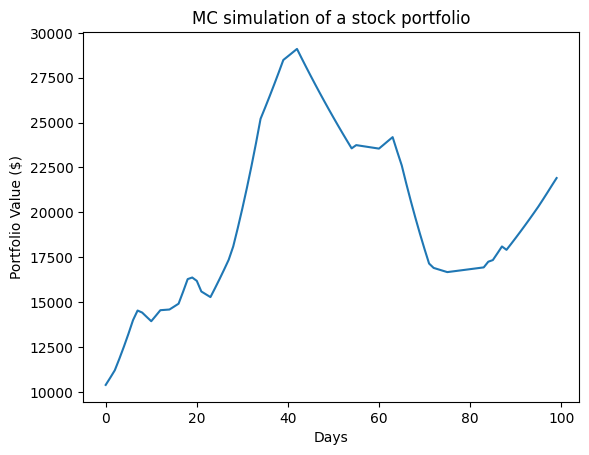

In [32]:
plt.plot(portfolio_sims_mcmc[:,0])
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()